In [1]:
import os
from random import shuffle
import tensorflow as tf

from tqdm import tqdm
import pandas as pd
import shutil
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.layers import (
    Dropout,
    Flatten,
    Dense,
    Input,
)
from tensorflow.keras.preprocessing.image import (
    load_img,
    img_to_array,
)
from sklearn.model_selection import train_test_split
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
import numpy as np

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
from ultralytics import YOLO

<h1> Pre-processing data


Chosen dataset: https://www.kaggle.com/datasets/biancaferreira/african-wildlife <br>
With this dataset I have 4 classes: buffalo, elephant, rhino, zebra. <br>
Each class have image + annotation. First step I need to divide the dataset into processed_data folder


In [4]:
data_path = "./data/"
processed_data_path = "./processed_data"
os.makedirs(processed_data_path, exist_ok=True)

In [5]:
labels_folder = os.listdir(data_path)

In [6]:
df = pd.DataFrame(columns=["class", "img_path", "x", "y", "w", "h"])

In [7]:
images_destination_folder = f"{processed_data_path}/images/"
labels_destination_folder = f"{processed_data_path}/labels/"
os.makedirs(images_destination_folder, exist_ok=True)
os.makedirs(labels_destination_folder, exist_ok=True)

Divide dataset into train, val folder and create dataframe


In [8]:
for label in tqdm(labels_folder):
    org_path = f"{data_path}/{label}"
    files = zip(os.listdir(org_path)[::2], os.listdir(org_path)[1::2])
    for img, file in tqdm(files):
        lb_file = f"{org_path}/{file}"
        img_path = f"{org_path}/{img}"
        numOfImage = len(os.listdir(images_destination_folder))
        img_new_path = os.path.join(
            images_destination_folder, f"africa{numOfImage}.jpg"
        )
        label_new_path = os.path.join(
            labels_destination_folder, f"africa{numOfImage}.txt"
        )
        shutil.copy(
            img_path,
            img_new_path,
        )
        shutil.copy(
            lb_file,
            label_new_path,
        )
        lb_info = open(lb_file, "r").read().split()
        objects = [[] for i in range(0, len(lb_info), 5)]
        for idx, obj_info in enumerate(lb_info):
            if idx % 5 == 0:
                continue
            else:
                objects[idx // 5].append(obj_info)
        for obj_list in objects:
            if obj_list:
                obj_details = obj_list

                lb = label
                x = float(obj_details[0])
                y = float(obj_details[1])
                w = float(obj_details[2])
                h = float(obj_details[3])

                row = {
                    "class": lb,
                    "img_path": img_new_path,
                    "x": x,
                    "y": y,
                    "w": w,
                    "h": h,
                }

                df = df.append(row, ignore_index=True)

376it [00:06, 54.84it/s]:00<?, ?it/s]
376it [00:07, 53.67it/s]:06<00:20,  6.86s/it]
376it [00:07, 52.71it/s]:13<00:13,  6.95s/it]
376it [00:07, 50.54it/s]:21<00:07,  7.03s/it]
100%|██████████| 4/4 [00:28<00:00,  7.11s/it]


In [9]:
df

,class,img_path,x,y,w,h
0,buffalo,./processed_data/images/africa1504.jpg,0.560000,0.663017,0.617500,0.644769
1,buffalo,./processed_data/images/africa1505.jpg,0.473515,0.508434,0.497592,0.838554
2,buffalo,./processed_data/images/africa1506.jpg,0.819167,0.593750,0.148333,0.242500
3,buffalo,./processed_data/images/africa1506.jpg,0.747500,0.472500,0.221667,0.190000
4,buffalo,./processed_data/images/africa1506.jpg,0.524167,0.543750,0.165000,0.232500
...,...,...,...,...,...,...
2680,zebra,./processed_data/images/africa3005.jpg,0.433594,0.518919,0.387500,0.656757
2681,zebra,./processed_data/images/africa3006.jpg,0.548828,0.492568,0.330469,0.974324
2682,zebra,./processed_data/images/africa3007.jpg,0.205859,0.592568,0.221094,0.520270
2683,zebra,./processed_data/images/africa3007.jpg,0.431641,0.597297,0.242969,0.562162


In [12]:
train_dir = "./processed_data/train/"
val_dir = "./processed_data/val"
labels_path = "./processed_data/labels/"

In [13]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(train_dir + "/images", exist_ok=True)
os.makedirs(train_dir + "/labels", exist_ok=True)
os.makedirs(val_dir + "/images", exist_ok=True)
os.makedirs(val_dir + "/labels", exist_ok=True)

In [14]:
files = os.listdir(images_destination_folder)
shuffle(files)

In [15]:
def split(files, ratio):
    elements = len(files)
    middle = int(elements * ratio)
    return [files[:middle], files[middle:]]


def copy_files(images_path, labels_path, destination_path, files):
    for file_name in files:
        file_name = file_name.split(".")[0]

        src = images_path + f"{file_name}.jpg"
        dst = destination_path + "/images"
        shutil.copy(src, dst)

        src = labels_path + f"{file_name}.txt"
        dst = destination_path + "/labels"
        shutil.copy(src, dst)

In [16]:
train_ratio = 0.75
train_files, val_files = split(files, train_ratio)

copy_files(images_destination_folder, labels_path, train_dir, train_files)
copy_files(images_destination_folder, labels_path, val_dir, val_files)

In [17]:
class_training = {idx: label for idx, label in enumerate(labels_folder)}
class_training

{0: 'buffalo', 1: 'elephant', 2: 'rhino', 3: 'zebra'}

In [18]:
with open(f"./processed_data/africa_data.yaml", "w") as f:
    f.write("train: ./train/images\n")
    f.write("val: ./val/images\n")
    f.write("nc: 4\n")
    f.write(f"names: {class_training}")

YOLOv8 model


In [19]:
model = YOLO("yolov8n.pt")

In [20]:
results = model.train(
    data="./processed_data/africa_data.yaml", epochs=10, imgsz=320
)
results = model.val()

New https://pypi.org/project/ultralytics/8.1.2 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.233 🚀 Python-3.9.13 torch-2.1.0+cpu CPU (AMD Ryzen 7 6800H with Radeon Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=./processed_data/africa_data.yaml, epochs=10, time=None, patience=50, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_

train: Scanning C:\Users\ADMIN\OneDrive - EPITA\Computer-Vision-DSA-23\Lab02\processed_data\train\labels... 1128 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1128/1128 [00:01<00:00, 654.84it/s]

train: WARNING ⚠️ C:\Users\ADMIN\OneDrive - EPITA\Computer-Vision-DSA-23\Lab02\processed_data\train\images\africa1438.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ C:\Users\ADMIN\OneDrive - EPITA\Computer-Vision-DSA-23\Lab02\processed_data\train\images\africa53.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ C:\Users\ADMIN\OneDrive - EPITA\Computer-Vision-DSA-23\Lab02\processed_data\train\images\africa788.jpg: corrupt JPEG restored and saved


train: New cache created: C:\Users\ADMIN\OneDrive - EPITA\Computer-Vision-DSA-23\Lab02\processed_data\train\labels.cache


val: Scanning C:\Users\ADMIN\OneDrive - EPITA\Computer-Vision-DSA-23\Lab02\processed_data\val\labels... 376 images, 0 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<00:00, 616.66it/s]

val: WARNING ⚠️ C:\Users\ADMIN\OneDrive - EPITA\Computer-Vision-DSA-23\Lab02\processed_data\val\images\africa784.jpg: corrupt JPEG restored and saved
val: New cache created: C:\Users\ADMIN\OneDrive - EPITA\Computer-Vision-DSA-23\Lab02\processed_data\val\labels.cache


Plotting labels to runs\detect\train7\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G     0.8388      2.153      1.048         12        320: 100%|██████████| 71/71 [01:07<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

                   all        376        674      0.728      0.574      0.673      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G     0.9038      1.383      1.091         11        320: 100%|██████████| 71/71 [01:09<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.15it/s]

                   all        376        674      0.651       0.53       0.59      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G     0.9286      1.304       1.09         13        320: 100%|██████████| 71/71 [01:08<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.20it/s]

                   all        376        674      0.731      0.682      0.768      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G     0.9306      1.231       1.09         13        320: 100%|██████████| 71/71 [01:05<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

                   all        376        674        0.8      0.704      0.787      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G     0.9224      1.146      1.094         10        320: 100%|██████████| 71/71 [01:05<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.20it/s]

                   all        376        674      0.731      0.714      0.774      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.8568      1.048      1.059         13        320: 100%|██████████| 71/71 [01:06<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.19it/s]

                   all        376        674      0.769      0.768      0.833      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G     0.8325     0.9825      1.045         15        320: 100%|██████████| 71/71 [01:05<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

                   all        376        674      0.852      0.766      0.843      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.7857     0.8758       1.02         13        320: 100%|██████████| 71/71 [01:11<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.16it/s]

                   all        376        674      0.839      0.807      0.871      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.7455     0.7935      1.006         13        320: 100%|██████████| 71/71 [01:06<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.15it/s]

                   all        376        674      0.912      0.801      0.894      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.6955     0.7364     0.9831         13        320: 100%|██████████| 71/71 [01:06<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.20it/s]

                   all        376        674      0.902      0.824      0.904      0.709



10 epochs completed in 0.217 hours.
Optimizer stripped from runs\detect\train7\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train7\weights\best.pt, 6.2MB

Validating runs\detect\train7\weights\best.pt...
Ultralytics YOLOv8.0.233 🚀 Python-3.9.13 torch-2.1.0+cpu CPU (AMD Ryzen 7 6800H with Radeon Graphics)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


                   all        376        674      0.902      0.824      0.904      0.708
               buffalo        376        135      0.874      0.785      0.869      0.698
              elephant        376        162      0.853      0.827      0.918      0.698
                 rhino        376        139      0.976      0.884       0.96      0.796
                 zebra        376        238      0.905        0.8      0.867      0.641
Speed: 0.2ms preprocess, 12.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\train7
Ultralytics YOLOv8.0.233 🚀 Python-3.9.13 torch-2.1.0+cpu CPU (AMD Ryzen 7 6800H with Radeon Graphics)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\ADMIN\OneDrive - EPITA\Computer-Vision-DSA-23\Lab02\processed_data\val\labels.cache... 376 images, 0 backgrounds, 0 corrupt: 100%|██████████| 376/376 [00:00<?, ?it/s]

val: WARNING ⚠️ C:\Users\ADMIN\OneDrive - EPITA\Computer-Vision-DSA-23\Lab02\processed_data\val\images\africa784.jpg: corrupt JPEG restored and saved



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:09<00:00,  2.62it/s]


                   all        376        674      0.909      0.822      0.905      0.707
               buffalo        376        135      0.884      0.785      0.872      0.699
              elephant        376        162      0.875      0.827       0.92      0.697
                 rhino        376        139      0.974      0.878       0.96      0.793
                 zebra        376        238      0.905      0.799      0.868       0.64
Speed: 0.2ms preprocess, 12.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\train72


SSD model


In [10]:
label_encoder = LabelBinarizer()

Because the dataset label is in Yolo Style(x, y, w, h) so with SSD I have to transform it into (x_min, y_min, x_max, y_max)


In [14]:
images = []
labels = []
bboxes = []
for index, row in tqdm(df.iterrows()):
    img_path = row["img_path"]
    original_img = load_img(img_path)
    w, h = original_img.size
    resized_img = original_img.resize((320, 320))
    resized_array = img_to_array(resized_img)
    resized_size = (320, 320)
    images.append(resized_array)

    x = row["x"]
    y = row["y"]
    w = row["w"]
    h = row["h"]
    x_min = (x - w / 2)
    y_min = (y - h / 2)
    x_max = (x + w / 2)
    y_max = (y + h / 2)
    bboxes.append((x_min, y_min, x_max, y_max))
    labels.append(row["class"])

2685it [00:24, 110.64it/s]


In [15]:
images = np.array(images, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
labels = label_encoder.fit_transform(labels)

In [16]:
(
    train_images,
    val_images,
    train_bboxes,
    val_bboxes,
    train_labels,
    val_labels,
) = train_test_split(images, bboxes, labels, test_size=0.20, random_state=12)

In [17]:
losses = {
    "class_label": "binary_crossentropy",
    "bounding_box": "mean_squared_error",
}

train_targets = {
    "class_label": train_labels,
    "bounding_box": train_bboxes,
}

val_targets = {
    "class_label": val_labels,
    "bounding_box": val_bboxes,
}

In [18]:
base_learning_rate = 0.00015

opt = Adam(base_learning_rate)

In [22]:
input_images = Input(shape=(320, 320, 3), name="input_images")

base_model = MobileNetV2(
    weights="imagenet", include_top=False, input_tensor=input_images
)
base_model.trainable = False
base_out = base_model.output
flatten_output = Flatten()(base_out)  # transform matrix into array 1D
bbox_layers = Dense(128, activation="relu")(flatten_output)
bbox_layers = Dense(64, activation="relu")(bbox_layers)
bbox_layers = Dense(32, activation="relu")(bbox_layers)
bbox_layers = Dropout(0.3)(bbox_layers)

label_layers = Dense(256, activation="relu")(flatten_output)
label_layers = Dense(128, activation="relu")(label_layers)

bounding_box = Dense(4, activation="sigmoid", name="bounding_box")(bbox_layers)
predictions_class = Dense(4, activation="sigmoid", name="class_label")(
    label_layers
)

model_ssd = Model(
    inputs=base_model.input,
    outputs=(bounding_box, predictions_class),
)
model_ssd.compile(
    optimizer=opt,
    loss=losses,
    metrics=["accuracy"],
)
model_ssd.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_images (InputLayer)      [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 160, 160, 32  864         ['input_images[0][0]']           
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 160, 160, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [23]:
with tf.device("/CPU:0"):
    model_ssd.fit(
        train_images,
        train_targets,
        validation_data=(
            val_images,
            val_targets,
        ),
        epochs=10,
        batch_size=128,
        verbose=1,
    )

Epoch 1/10


17/17 [==============================] - 55s 3s/step - loss: 0.2163 - bounding_box_loss: 0.0508 - class_label_loss: 0.1655 - bounding_box_accuracy: 0.5549 - class_label_accuracy: 0.8827 - val_loss: 0.0497 - val_bounding_box_loss: 0.0376 - val_class_label_loss: 0.0121 - val_bounding_box_accuracy: 0.5847 - val_class_label_accuracy: 0.9907
Epoch 2/10
17/17 [==============================] - 44s 3s/step - loss: 0.0419 - bounding_box_loss: 0.0388 - class_label_loss: 0.0031 - bounding_box_accuracy: 0.5815 - class_label_accuracy: 0.9995 - val_loss: 0.0389 - val_bounding_box_loss: 0.0336 - val_class_label_loss: 0.0054 - val_bounding_box_accuracy: 0.6574 - val_class_label_accuracy: 0.9981
Epoch 3/10
17/17 [==============================] - 44s 3s/step - loss: 0.0352 - bounding_box_loss: 0.0345 - class_label_loss: 7.2972e-04 - bounding_box_accuracy: 0.6103 - class_label_accuracy: 0.9995 - val_loss: 0.0396 - val_bounding_box_loss: 0.0349 - val_class_label_loss: 0.0047 - val_bounding_box_accuracy:

In [25]:
model_ssd.save("./ssd_model/model.h5")

<h1> Model Prediction


In [5]:
model_yolo_loaded = YOLO("./runs/detect/train7/weights/best.pt")

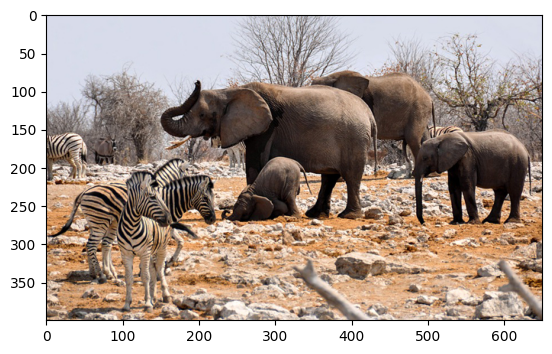

In [6]:
img_org = load_img("./savane-070553-650-400.jpg")

plt.imshow(img_org)
plt.show()

In [7]:
detections = model_yolo_loaded.predict(img_org, imgsz=320)


0: 224x320 4 elephants, 4 zebras, 32.2ms
Speed: 1.0ms preprocess, 32.2ms inference, 1.5ms postprocess per image at shape (1, 3, 224, 320)


In [8]:
yolo_rs = model_yolo_loaded([img_org], imgsz=320)
yolo_rs


0: 224x320 4 elephants, 4 zebras, 25.6ms
Speed: 0.0ms preprocess, 25.6ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 320)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'buffalo', 1: 'elephant', 2: 'rhino', 3: 'zebra'}
 orig_img: array([[[234, 219, 216],
         [234, 219, 216],
         [234, 219, 216],
         ...,
         [235, 220, 217],
         [235, 220, 217],
         [235, 220, 217]],
 
        [[234, 219, 216],
         [234, 219, 216],
         [234, 219, 216],
         ...,
         [235, 220, 217],
         [235, 220, 217],
         [235, 220, 217]],
 
        [[234, 219, 216],
         [234, 219, 216],
         [234, 219, 216],
         ...,
         [235, 220, 217],
         [235, 220, 217],
         [235, 220, 217]],
 
        ...,
 
        [[150, 180, 207],
         [170, 206, 230],
         [180, 212, 235],
         ...,
         [ 65,  75,  92],
         [ 54,  65,  87],
         [ 57,  71,  94]],
 
        [[163, 190, 227],
         [158, 185, 222],
         [153, 184, 217],
   

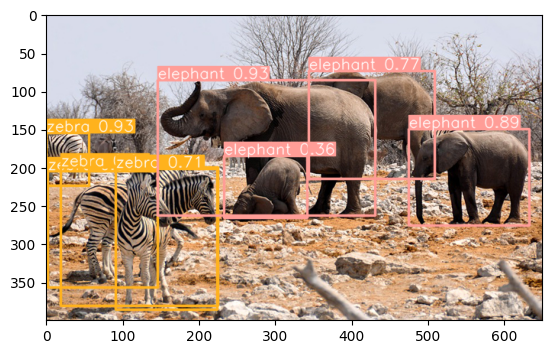

In [9]:
for r in yolo_rs:
    im_array = r.plot()
    im = Image.fromarray(im_array[..., ::-1])
    plt.imshow(im)

In [26]:
ssd_loaded_model = load_model("./ssd_model/model.h5", compile=False)

In [27]:
import cv2

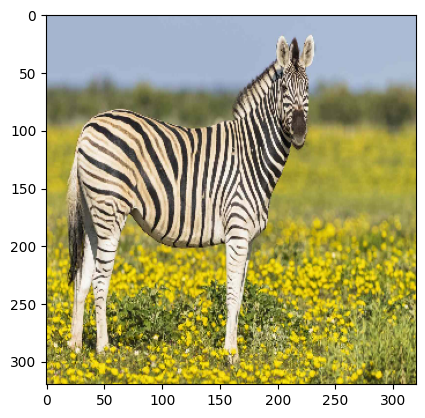

In [28]:
img_org = cv2.imread("./test_zebra.jpg")
img_org = cv2.resize(img_org, (320, 320))
# img = img / 255.0
plt.imshow(cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB))
plt.show()

In [29]:
img = img_org.reshape(1, 320, 320, 3)
img = np.array(img, dtype="float32") / 255.0

In [30]:
prediction = ssd_loaded_model.predict(img)
bbox = prediction[0][0] * 320.0
label = np.argmax(prediction[1], axis=1)

1/1 [==============================] - 8s 8s/step


In [31]:
xmin, ymin, xmax, ymax = np.array(bbox, dtype=int)

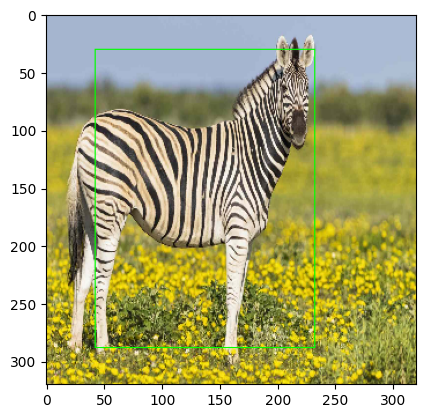

In [32]:
image = cv2.rectangle(img_org, (xmin, ymin), (xmax, ymax), (0, 255, 0))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()